# Picture similarity based on pretrained model

In [1]:
%matplotlib inline
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

Using TensorFlow backend.


Loading pretrained VGG16

In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Defining new feature extraction model that will output the last dense layer of VGG16

In [3]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Image preprocessing function

In [4]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Loading the name of max 10000 picture from the defined folder

In [6]:
images_path="./pics/"
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1052 images to analyze


Loading files from target folder, preprocess and extract feature vector. Exception handling is necessary due to corrupted images.

In [7]:
features = []
new_images=[]
for image_path in tqdm(images):
    try:
        img, x = get_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat)
        new_images.append(image_path)
    except:
        print("problem with {}".format(image_path))

 36%|█████████████▊                         | 374/1052 [05:16<09:34,  1.18it/s]

problem with ./pics/DSCN3053.JPG


100%|██████████████████████████████████████| 1052/1052 [14:45<00:00,  1.19it/s]


Size of feature vector is 4096. To make search more effective we use PCA to surpress into 300 dim. Make sense to investigate other numbers.

In [119]:
features = np.array(features)
pca = PCA(n_components=200)
pca.fit(features)
pca_features = pca.transform(features)

Functions to find most simillar images and to represent their picture

In [115]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    distances = list(np.array(distances)[idx_closest])
    return idx_closest, distances

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(new_images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [108]:
def random_pic_similarity_label(idx=0):
    # do a query on a random image
    if (idx==0):
        query_image_idx = int(len(images) * random.random())
    else:
        query_image_idx = idx
    idx_closest = get_closest_images(query_image_idx)[0]
    query_image = get_concatenated_images([query_image_idx], 300)
    results_image = get_concatenated_images(idx_closest, 200)

    # display the query image
    matplotlib.pyplot.figure(figsize = (5,5))
    imshow(query_image)
    matplotlib.pyplot.title("query image (%d)" % query_image_idx)

    # display the resulting images
    matplotlib.pyplot.figure(figsize = (16,12))
    imshow(results_image)
    matplotlib.pyplot.title("distances: "+", ".join(map(str,get_closest_images(query_image_idx)[1])))

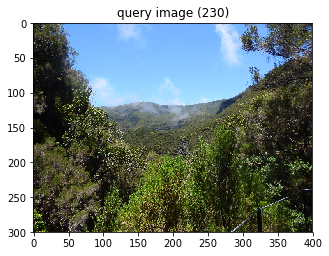

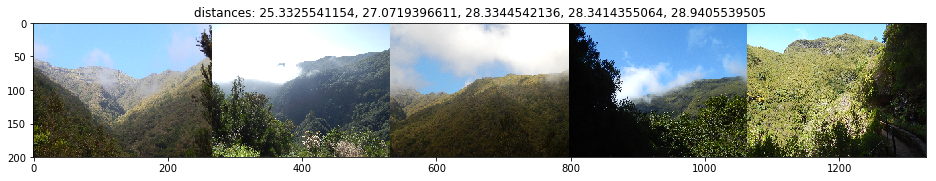

In [121]:
random_pic_similarity_label(230)

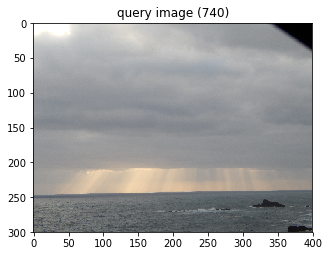

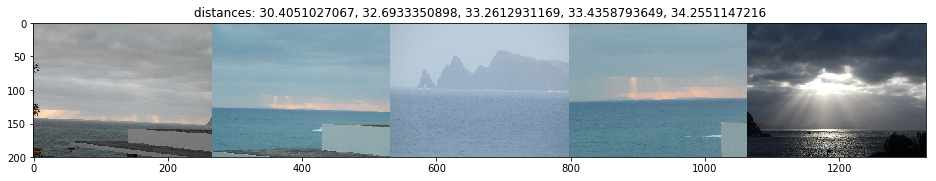

In [122]:
random_pic_similarity_label(740)

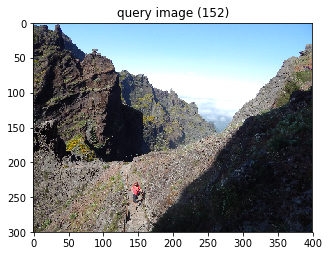

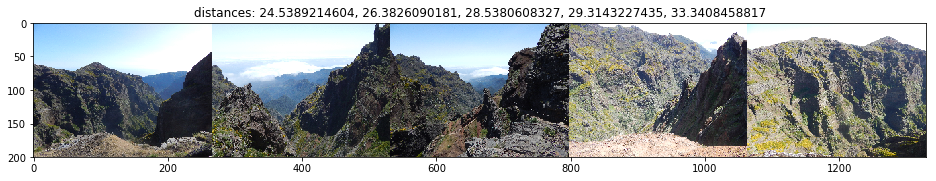

In [129]:
random_pic_similarity_label(152)

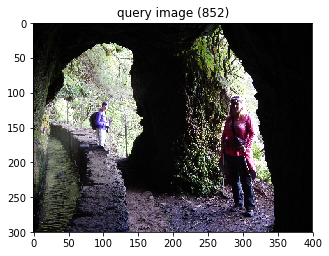

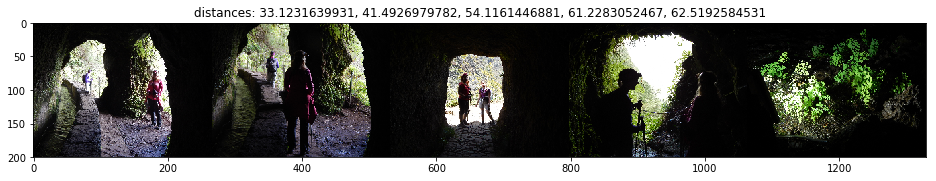

In [130]:
random_pic_similarity_label(852)

In [135]:
import sys
sys.getsizeof(pca_features)/1024**2

1.6038055419921875